In [1]:
import pandas as pd
import numpy as np 

import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use(['fast', 'dark_background'])
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm, tree, linear_model, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import pos_tag, FreqDist, word_tokenize
from wordcloud import WordCloud, STOPWORDS

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print('train data:'% train.columns, train.shape, len(train))
print('test data:'% test.columns, test.shape, len(test))

train data: (31962, 3) 31962
test data: (17197, 2) 17197


Upper and lower case words will be considered even if meanings are identical

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
# Pre-proc

# regular expression matchmaking operations 
import re

def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

train_clean = clean_text(train, "tweet")
test_clean = clean_text(test, "tweet")

print(train_clean.head())

   id  label                                              tweet
0   1      0    when a father is dysfunctional and is so sel...
1   2      0    thanks for lyft credit i cant use cause they...
2   3      0                                bihday your majesty
3   4      0  model   i love u take with u all the time in u...
4   5      0               factsguide society now    motivation


In [5]:
# Check class imbalance 

train_clean['label'].value_counts()

# imbalance may induce model to default to predicting all labels as 0

0    29720
1     2242
Name: label, dtype: int64

In [6]:
# Resampling 
    # positive = majority 
    # negative = minority 

from sklearn.utils import resample 

train_maj = train_clean[train_clean.label == 0]

train_min = train_clean[train_clean.label == 1]

# Upsampling 
    # function to retrive samples from minority class via replacement 
        # until class size identical to majority
    
train_min_upsamp = resample(train_min, replace = True, 
                            n_samples = len(train_maj),
                            random_state = 42)

train_upsamp = pd.concat([train_min_upsamp,train_maj])

train_upsamp['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

Upsampling retrieves from majority, without replacement. 

In [7]:
pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('nb', SGDClassifier()),])

# Split train 
x_train, x_test, y_train, y_test = train_test_split(train_upsamp['tweet'],
                                                    train_upsamp['label'],
                                                    random_state = 0)

In [8]:
model = pipeline.fit(x_train, y_train)

y_predict = model.predict(x_test)

f1_score(y_test, y_predict)

0.9688645909727315

In [9]:
df = train.copy()
df.head()

,id,label,tweet
0,1,0,when a father is dysfunctional and is so sel...
1,2,0,thanks for lyft credit i cant use cause they...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in u...
4,5,0,factsguide society now motivation


In [10]:
# Features 

# Include only alpha-numeric characters

# Retrieve hastags from all rows 
#hashtags = df['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))

#df.loc[:, 'hashtags'] = hashtags['hashtag']

#df['hashtags'].fillna('', inplace = True)

# Remove @user 
    # mentions = @user 

#df['tweet'] = df['tweet'].str.replace('@[a-zA-Z0-9_]+', ' ') # match underscore character, lowercase, uppercase, numbers

#df['tweet'] = df['tweet'].str.replace('#(?P<hashtag>[a-zA-Z0-9_]+)', ' ')

# Only keep words
    # replace others with blanks 
#df['tweet'] = df['tweet'].str.replace('[^a-zA-Z]', ' ') # match all strings that have non-letters 

In [11]:
hashtags = df['tweet'].str.extractall('#(?P<hashtag>[a-zA-Z0-9_]+)').reset_index().groupby('level_0').agg(lambda x: ' '.join(x.values))
df.loc[:, 'hashtags'] = hashtags['hashtag']
df['hashtags'].fillna('', inplace=True)

df.loc[:, 'mentions'] = df['tweet'].str.count('@[a-zA-Z0-9_]+')

df.tweet = df.tweet.str.replace('@[a-zA-Z0-9_]+', '')

In [12]:
df.head()

,id,label,tweet,hashtags,mentions
0,1,0,when a father is dysfunctional and is so sel...,,0
1,2,0,thanks for lyft credit i cant use cause they...,,0
2,3,0,bihday your majesty,,0
3,4,0,model i love u take with u all the time in u...,,0
4,5,0,factsguide society now motivation,,0


Reduce morphological variation 
Lem deals only with inflectional var
Stem deals with derivational AND inflectional var 

In [13]:
# Lem words 
lem = WordNetLemmatizer() # return dictionary form of words based on context

# Stem hastags 
stem = SnowballStemmer('english') # remove ends of words, no context 

# Tag parts of tweet sentence
a = {'N' : 'n',
     'V' : 'v',
     'J' : 'a',
     'S' : 's',
     'R' : 'r'}

def tag(penn_tag):
    if penn_tag in a.keys():
        return a[penn_tag]
    else:
        return 'n'
    
def tag_lem(element):
    sentence = pos_tag(word_tokenize(element))
    return ' '.join([lem.lemmatize(sentence[k][0], tag(sentence[k][1][0]))
                    for k in range(len(sentence))])

In [14]:
df.loc[:, 'tweet'] = df['tweet'].apply(lambda x: tag_lem(x))

df.loc[:, 'hashtags'] = df['hashtags'].apply(lambda x: ' '.join([stem.stem(word) for word in x.split()]))

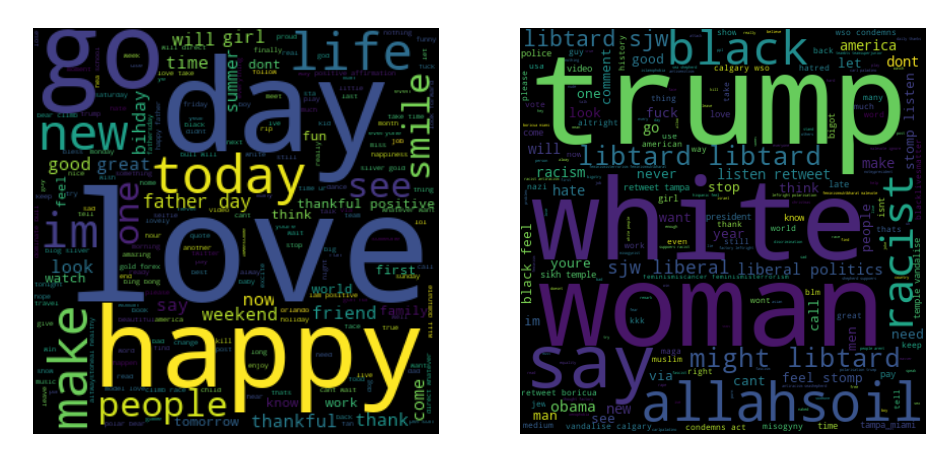

In [15]:
# Most common words
stopwords = STOPWORDS.add('amp')

words = ' '.join(df.tweet.values)
profanity = ' '.join(df[df.label != 0].tweet.values) # 0 = 'non profane'

plt.figure(figsize = (16, 8))

cloud = WordCloud(width = 300, height = 300, background_color = 'black',
                 stopwords = stopwords).generate(words)

plt.subplot(121)
plt.imshow(cloud, interpolation = "bilinear")
plt.axis("off")
plt.title('tweets', size = 20)

cloud1 = WordCloud(width=400, height=400, background_color = 'black', 
                   stopwords = stopwords).generate(profanity)
plt.subplot(122)
plt.imshow(cloud1, interpolation = "bilinear")
plt.axis("off")
plt.title('tweets with profanity', size=20)
plt.show()

In [16]:
# Hashtag distribution
tags = FreqDist(list(' '.join(df.hashtags.values).split())).most_common(10)

potty_tags = FreqDist(list(' '.join(df[df.label != 0].hashtags.values).split())).most_common(10)

TypeError: Empty 'DataFrame': no numeric data to plot

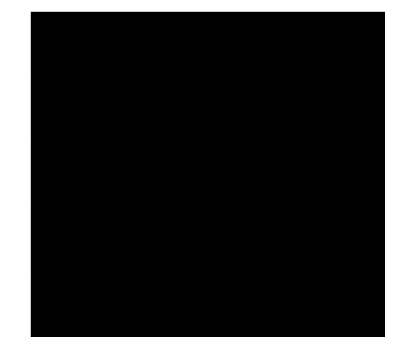

In [17]:
plt.figure(figsize = (14, 6))

ax = plt.subplot(121)
pd.DataFrame(tags, columns = ['hashtags', 'Count']).set_index('hashtags').plot.barh(ax = ax, 
                                                                            fontsize = 10)
plt.xlabel('frequency')
plt.title('Hashtags usage', size = 10)

ax = plt.subplot(122)
pd.DataFrame(potty_tags, columns = ['hashtags', 'Count']).set_index('hashtags').plot.barh(ax = ax, 
                                                                                 fontsize = 10)
plt.xlabel('freq')
plt.title('Potty hashtags', size = 10)
plt.show();

In [18]:
print('Mention count: {} \ntweets with mention: {} \nCorrelation with label: {}'.format(df.mentions.sum(),
                                                                                    len(df[df.mentions > 0]),
                                                                                           np.corrcoef(df.mentions, 
                                                                                                       df.label)[0][1]))

Mention count: 0 
tweets with mention: 0 
Correlation with label: nan


/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [19]:
df.drop('mentions', axis = 1, inplace = True)

In [20]:
# Word freq as features
vec = TfidfVectorizer(stop_words = stopwords.words('english'),
                      ngram_range = (1, 3), 
                      min_df = 10)

features = vec.fit_transform(df.tweet)

AttributeError: 'NoneType' object has no attribute 'words'

In [21]:
features

NameError: name 'features' is not defined

In [22]:
x_train, x_test, y_train, y_test = train_test_split(features, df.label)

NameError: name 'features' is not defined

In [23]:
# logit 
params = {'penalty': ['l1', 'l2'], 'C': [3, 10, 30, 100, 300]}

logit = GridSearchCV(LogisticRegression(solver = 'liblinear', max_iter = 150), 
                     param_grid = params, 
                     scoring = 'f1', cv = 10, n_jobs = 1)

logit.fit(x_train, y_train)
print("Best parameters found were {} with F1 of {:.2f}".format(
    logit.best_params_,
    logit.best_score_
))

proba = logit.predict_proba(x_test)
thresholds = np.arange(0.1, 0.9, 0.1)
scores = [f1_score(y_test, (proba[:, 1] >= x).astype(int)) for x in thresholds]

plt.plot(thresholds, scores, 'o-')
plt.title('f1 across thresholds')
plt.ylabel('score')
plt.xlabel('threshold')
plt.show();

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: could not convert string to float: 'sikh temple vandalised in in calgary wso condemns  act   '

P(tweet) >= 0.4 classified as tweet with profanity / hate speech

In [24]:
params = {'C': [1000, 3000, 9000, 15000]}
svc = GridSearchCV(SVC(kernel = 'rbf', gamma = 'auto'), 
                   param_grid = params, 
                   scoring = 'f1', cv = 3, n_jobs = -
                   1)
svc.fit(X_train, y_train)
print("Best parameters found were {} with F1 score of {:.2f}".format(
    svc.best_params_,
    svc.best_score_
))
predictions = svc.predict(X_test)
print("\nF1 test score for SVC: {:.2f}".format(f1_score(y_test, predictions)))

NameError: name 'X_train' is not defined

In [25]:
pred = svc.predict(x_test)

print('\n SVC f score: {:.2f}'.format(f1_score(y_test, pred)))

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

F1:

Logit = 0.64
SVC = 0.67

In [26]:
# Optimize svc 
params = {'C': [1000, 3000, 9000, 15000]}
svc = GridSearchCV(SVC(kernel = 'rbf', gamma = 'auto'), 
                   param_grid = params, 
                   scoring = 'roc_auc', cv = 3, n_jobs = -
                   1)
svc_fit = svc.fit(x_train, y_train)
svc_opt = svc_fit.best_estimator_
results = svc.cv_results_

ValueError: could not convert string to float: 'come on n wake the eff up usa this is craziness does it all stem from  n hatred of obama  it seems like '

In [27]:
svc_opt.fit(x_train, y_train) # fit optimised model to the train set

pred = svc_opt.predict(x_test) # predict probabilities

svc_roc_auc = roc_auc_score(y_test, pred) # calc AUC using test set

print('AUC score: %.3f' % svc_roc_auc)

NameError: name 'svc_opt' is not defined

In [28]:
# Optimize logit 
param_grid = {'C': np.arange(1e-03, 2, 0.01)}

log_gs = GridSearchCV(LogisticRegression(solver = 'liblinear', class_weight = 'balanced',
                                             random_state = 7), 
                         iid = True,
                         return_train_score = True,
                         param_grid = param_grid,
                         scoring = 'roc_auc',
                         cv = 10)

log_grid = log_gs.fit(x_train, y_train)
log_opt = log_grid.best_estimator_
results = log_gs.cv_results_

print('='*20)
print('best params =' + str(log_gs.best_estimator_))
print('best params =' + str(log_gs.best_params_))
print('best score =', log_gs.best_score_)
print('='*20)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: could not convert string to float: 'sikh temple vandalised in in calgary wso condemns  act   '

In [29]:
# C matrix 
cnf_matrix = metrics.confusion_matrix(y_test, log_opt.predict(x_test))
class_names=[0,1] 

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Vis
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True ,fmt='g')

ax.xaxis.set_label_position("top")
plt.tight_layout()

plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual attrition')
plt.xlabel('Predicted attrition')

NameError: name 'log_opt' is not defined

In [30]:
print('Logit ACC on test: {:.2f}'.format(log_opt.score(x_test, y_test)*100))

NameError: name 'log_opt' is not defined

In [31]:
log_opt.fit(x_train, y_train) # fit optimised model to the train set

probs = log_opt.predict_proba(x_test) # predict probabilities

probs = probs[:, 1] #  only keep probabilities associated with former

logit_roc_auc = roc_auc_score(y_test, probs) # calc AUC using test set

print('AUC score: %.3f' % logit_roc_auc)

NameError: name 'log_opt' is not defined

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, log_opt.predict_proba(x_test)[:,1])
plt.figure(figsize = (15, 8))

plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' %logit_roc_auc)

plt.plot([0, 1], label = 'Base Rate')

plt.xlabel('FPR (1 - specificity)')
plt.ylabel('TPR (senstivity)')
plt.title('Logit ROC')
plt.style.use(['fast', 'dark_background'])
plt.legend(loc = 'lower right')
plt.show();

NameError: name 'log_opt' is not defined

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, svc_opt.predict(x_test))
plt.figure(figsize = (15, 8))

plt.plot(fpr, tpr, label = 'SVC (area = %0.2f)' %svc_roc_auc)

plt.plot([0, 1], label = 'Base Rate')

plt.xlabel('FPR (1 - specificity)')
plt.ylabel('TPR (senstivity)')
plt.title('SVC ROC')
plt.style.use(['fast', 'dark_background'])
plt.legend(loc = 'lower right')
plt.show();

NameError: name 'svc_opt' is not defined

In [34]:
plt.figure(figsize = (15, 8))

fpr, tpr, thresholds = roc_curve(y_test, log_opt.predict_proba(x_test)[:,1])
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' %logit_roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, svc_opt.predict(x_test))
plt.plot(fpr, tpr, label = 'SVC (area = %0.2f)' %svc_roc_auc)

plt.plot([0, 1], label = 'Base Rate')

plt.xlabel('FPR (1 - specificity)')
plt.ylabel('TPR (senstivity)')
plt.title('Logit & SVC ROC')
plt.style.use(['fast', 'dark_background'])
plt.legend(loc = 'lower right')
plt.show();

NameError: name 'log_opt' is not defined

<Figure size 1080x576 with 0 Axes>

In [35]:
# Correct for class imbalance 